In [355]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from typing import List, Tuple

In [356]:
class TruncatedNormal(torch.distributions.Normal):
    def __init__(self, loc: float, scale: float, lo: float, hi: float):
        super().__init__(loc, scale)
        self.lo = lo
        self.hi = hi
        
    def sample(self, sample_shape=torch.Size()):
        sampled = super().sample(sample_shape)
        return sampled.clamp(self.lo, self.hi)
        

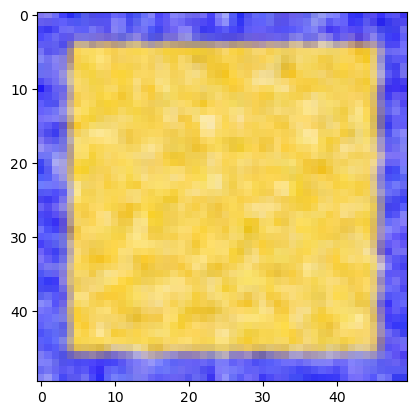

In [357]:
hue_range = [22, 37]
saturation_range = [0, 255]
value_range = [180, 255]
hue_mean = 30
saturation_mean = 200
value_mean = 255
hue_dist = TruncatedNormal(TruncatedNormal(hue_mean, 7, *hue_range).sample(), 3, *hue_range)
hue_dist2 = TruncatedNormal(TruncatedNormal(120, 9, 105, 130).sample(), 5, 105, 130)
saturation_dist = TruncatedNormal(saturation_mean, 200, *saturation_range)
value_dist = TruncatedNormal((value_mean - value_range[0]) / (value_range[1] - value_range[0]), 0.5, 0, 1)

channel_shape = 100, 100
border_width = np.random.randint(8, 12)
hue = hue_dist.sample(channel_shape)
hue2 = hue_dist2.sample(channel_shape)
hue, hue2 = cv2.blur(np.array(hue), (3, 3)), cv2.blur(np.array(hue2), (3, 3))
hue2[border_width:-border_width, border_width:-border_width] = hue[border_width:-border_width, border_width:-border_width]
saturation = saturation_dist.sample(channel_shape)
value_interval = saturation / (saturation_range[1] - saturation_range[0]) * (value_range[1] - value_range[0])
value = value_range[1] - (1 - value_dist.sample(channel_shape)) * value_interval

background = np.stack([hue2, saturation, value], axis=2).astype(np.uint8)

lemon_label_image = cv2.cvtColor(background, cv2.COLOR_HSV2RGB)
lemon_label_image = cv2.blur(lemon_label_image, (4, 4))
plt.imshow(cv2.resize(lemon_label_image, (50, 50), interpolation=cv2.INTER_AREA))

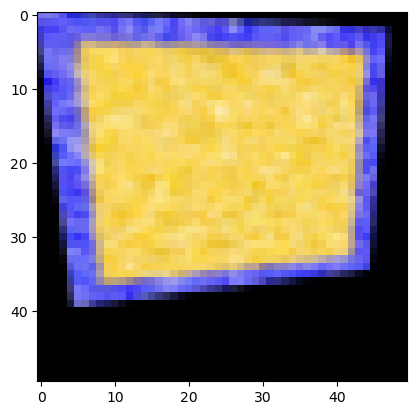

In [358]:
pts1 = np.float32([[0, 0], [0, channel_shape[1]], channel_shape, [channel_shape[0], 0]])
pts2 = np.float32([[0, 0], [10, 80], [90, 70], [95, 5]]) * 3
P = cv2.getPerspectiveTransform(pts1, pts2)
dst_perspective = cv2.warpPerspective(lemon_label_image, P, (300, 300))
plt.imshow(cv2.resize(dst_perspective, (50, 50), interpolation=cv2.INTER_AREA))

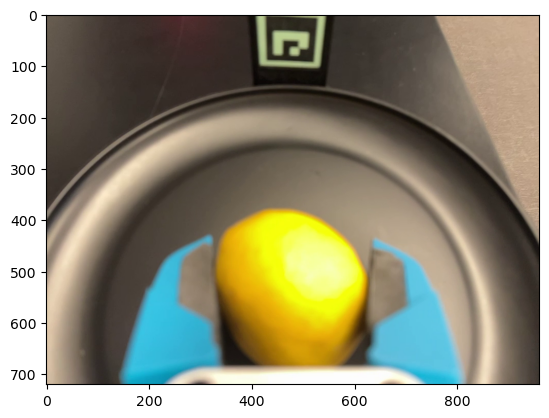

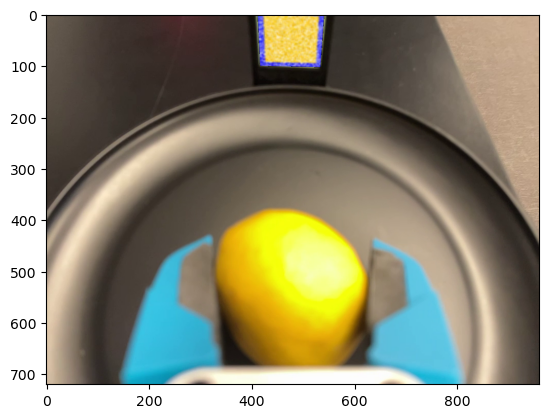

<Figure size 640x480 with 0 Axes>

In [359]:
import decord
import einops
import cv2.aruco as aruco
from pathlib import Path


def video_frames_extractor(video_path: Path):
  vr = decord.VideoReader(str(video_path), ctx=decord.cpu(0))
  frames = []
  for i in range(len(vr)):
    frame = cv2.cvtColor(vr[i].asnumpy(), cv2.COLOR_RGB2BGR)
    # draw_marker(frame)
    frames.append(frame)
  return frames


#
# line segment intersection using vectors
# see Computer Graphics by F.S. Hill
#

def perp(a) :
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

# line segment a given by endpoints a1, a2
# line segment b given by endpoints b1, b2
# return 
def seg_intersect(a1,a2, b1,b2) :
    da = a2 - a1
    db = b2 - b1
    dp = a1 - b1
    dap = perp(da)
    denom = np.dot(dap, db)
    num = np.dot(dap, dp)
    return (num / denom.astype(float)) * db + b1

def scale_quadrilateral(points: List[Tuple[float]], scale_factor: float) -> List[Tuple[float]]:
  center = seg_intersect(points[0], points[2], points[1], points[3])
  return [(point - center) * scale_factor + center for point in points]


frame = video_frames_extractor(Path('../data/RGB_2025-03-05-14_58_10.mp4'))[90]
frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
parameters =  aruco.DetectorParameters()
aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_4X4_50)
detector = aruco.ArucoDetector(aruco_dict, parameters)

# Detect ArUco markers
marker_corners, marker_ids, rejectedCandidates = detector.detectMarkers(gray)
marker_corners, marker_ids = [i[0] for i in marker_corners], [i[0] for i in marker_ids]
marker_corners = [scale_quadrilateral(corners, 1.3) for corners in marker_corners]

pts1 = np.float32([[0, 0], [0, channel_shape[1]], channel_shape, [channel_shape[0], 0]])
pts2 = np.float32(marker_corners[0])
H, _ = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)

mapped_label = cv2.warpPerspective(lemon_label_image, H, (frame.shape[1], frame.shape[0]))
gray_mapped_label = cv2.cvtColor(mapped_label, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray_mapped_label, 1, 255, cv2.THRESH_BINARY)
mask_inv = cv2.bitwise_not(mask)

dest_bg = cv2.bitwise_and(frame, frame, mask=mask_inv)
warped_fg = cv2.bitwise_and(mapped_label, mapped_label, mask=mask)
final_img = cv2.add(dest_bg, warped_fg)

def show(image):
  plt.imshow(np.flip(cv2.resize(image, (frame.shape[1], frame.shape[0]), interpolation=cv2.INTER_AREA).transpose(1, 0, 2), axis=0))
  plt.figure()
show(frame)
show(final_img)

(960, 720, 3)
(960, 720)
(960, 720)
(962, 722, 3)


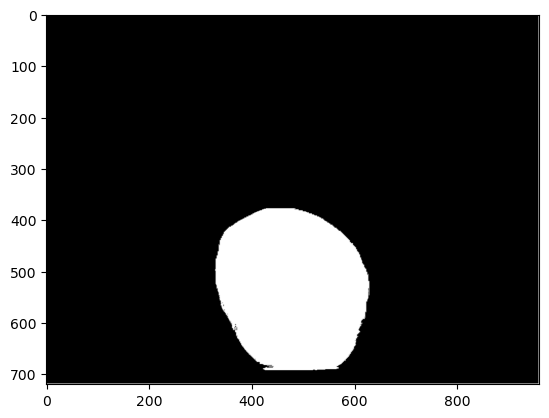

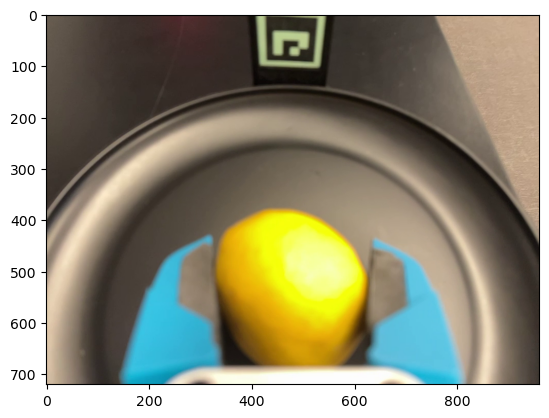

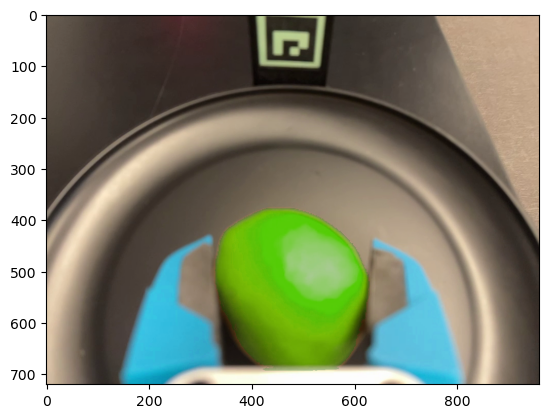

<Figure size 640x480 with 0 Axes>

In [360]:
mask = np.zeros((frame.shape[0] + 2, frame.shape[1] + 2), np.uint8)
copy = cv2.cvtColor(frame.copy(), cv2.COLOR_RGB2HSV)
hue_range = [22, 37]
saturation_range = [0, 255]
value_range = [180, 255]
print(copy.shape)
yellow_mask = np.zeros(copy.shape[:-1]).astype(np.uint8)
print(yellow_mask.shape)
num_saturation_slices = 12
for i in range(num_saturation_slices):
  min_saturation = max(int(i / num_saturation_slices * 255), 60)
  min_value = min(255 - min_saturation, 240)
  mask_slice = cv2.inRange(copy, (14, min_saturation, min_value), (37, 255, 255))
  yellow_mask = yellow_mask | mask_slice
# yellow_mask = cv2.inRange(copy, (14, 0, 250), (35, 255, 255))
print(yellow_mask.shape)

yellow_regions = cv2.bitwise_and(copy, copy, mask=yellow_mask)

r = (10, 60, 30)
cv2.floodFill(yellow_regions, mask, (220, 480), (255, 0, 0), r, r)
print(np.expand_dims(mask, axis=2).repeat(3, axis=2).shape)
show(np.expand_dims(mask, axis=2).repeat(3, axis=2) * 255)

hue_diff = np.zeros_like(copy).astype(np.float16)
# hue_diff[:, :, 0] = 18
hue_shifted = copy + hue_diff
hue_shifted[:, :, 0] = (hue_shifted[:, :, 0] - 28) * 0.7 + 28 + 18
# hue_shifted[:, :, 1] *= 1.4
hue_shifted[:, :, 2] = hue_shifted[:, :, 2] * 0.8
hue_shifted = np.clip(hue_shifted, 0, 255).astype(np.uint8)
# lime = cv2.colorChange(frame, mask[1:-1, 1:-1], red_mul=0.2, green_mul=1.2)
hue_shifted_bgr = cv2.cvtColor(hue_shifted, cv2.COLOR_HSV2RGB)
# show(hue_shifted_bgr)
show(frame)

lemon_mask = mask[1:-1, 1:-1]
background_mask = cv2.bitwise_not(lemon_mask * 255)

background = cv2.bitwise_and(copy, copy, mask=background_mask)
lime = cv2.bitwise_and(hue_shifted, hue_shifted, mask=lemon_mask)
lemon_to_lime = cv2.add(background, lime)
show(cv2.cvtColor(lemon_to_lime, cv2.COLOR_HSV2RGB))